## Feature Engineering, Logistic Regression, Cross Validation





In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

Loading the data 

In [6]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Mon Apr 15 13:38:43 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Apr 15 13:38:44 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Checking for missing values within the training dataset

In [8]:
original_training_data=original_training_data.fillna('')
original_training_data.isnull().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

Looking at spam and non-spam emails to identify differences 

In [9]:
first_ham = original_training_data.loc[0]['email'] 
first_spam = original_training_data.loc[2]['email']
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



## Training Validation Split

In [10]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

Basic Feature Engineering

The words_in_text function takes in a list of `words` and a pandas Series of email `texts` and outputs an array that contains either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does

In [11]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    whole_array=np.array([int(q in u) for u in texts for q in words])
    indicator_array = np.array_split((whole_array),len(texts))
    return indicator_array

Now lets do some Basic EDA

In [12]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


Now lets choose some words and see how often they occur in each type of email

Text(0.5, 1.0, 'Frequency of Words in Ham/Spam Emails')

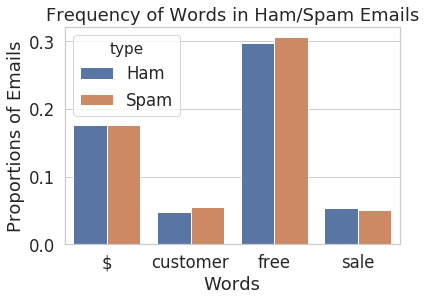

In [13]:
words=['customer','free','sale','$']
b=pd.DataFrame(words_in_texts(words,train['email']))
b['type']=train['spam'].replace({0:'Ham',1:'Spam'})
b=b.rename(index=str, columns={0: words[0], 1: words[1],2:words[2],3:words[3]})
b=b.melt('type')
new=b.groupby(['variable','type'])['value'].sum().reset_index()
lspam=len(train[train['spam']==1])
lham=len(train[train['spam']==0])
hamprop=np.array(new[new['type']=='Ham']['value']/lham)
spamprop=np.array(new[new['type']=='Spam']['value']/lspam)
new['proportions']=hamprop[0],spamprop[0],hamprop[1],spamprop[1],hamprop[2],spamprop[2],hamprop[3],spamprop[3]

sns.barplot(x='variable', y='proportions', hue='type', data=new)
plt.xlabel('Words')
plt.ylabel('Proportions of Emails')
plt.title('Frequency of Words in Ham/Spam Emails')

The length of the email body can also be useful when trying to identify spam emails. 

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Distribution')

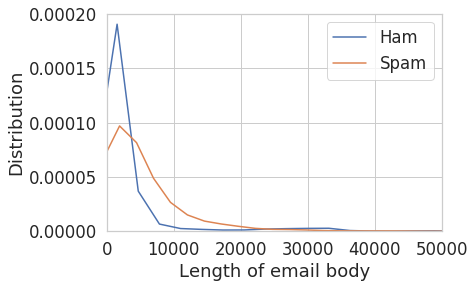

In [14]:
ham_data=train[train['spam']==0]
spam_data=train[train['spam']==1]
ham_data['length']=ham_data['email'].str.len()
spam_data['length']=spam_data['email'].str.len()
sns.distplot(ham_data['length'],hist=False, label='Ham')
sns.distplot(spam_data['length'],hist=False, label= 'Spam')
plt.xlim(0,50000)
plt.legend()
plt.xlabel('Length of email body')
plt.ylabel('Distribution')

Now that we have a rough idea of the dataset, let's start on working on actually classifying the data. These 5 words might be useful as features to distinguish spam/ham emails. We use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

In [15]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = np.array(words_in_texts(some_words,train['email']))
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)

Now that we have our training sets, we can train a logistic regression model using scikit and our matrices. We will also display the accuracy of the model

In [16]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,Y_train)


training_accuracy = lr.score(X_train,Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


We can also calculate the precision, recall and false alarm rates of our model 

In [19]:
logistic_predictor_precision = np.count_nonzero(lr.predict(X_train) & Y_train) / (np.count_nonzero(lr.predict(X_train) & Y_train) + np.count_nonzero(lr.predict(X_train) & (~Y_train)))
logistic_predictor_recall = np.count_nonzero(lr.predict(X_train) & Y_train) / (np.count_nonzero(lr.predict(X_train) & Y_train) + np.count_nonzero((~lr.predict(X_train)) & Y_train))
logistic_predictor_far = np.count_nonzero(lr.predict(X_train) & (~Y_train)) / ((np.count_nonzero(lr.predict(X_train) & (~Y_train))) + np.count_nonzero((~lr.predict(X_train)) & (~Y_train)))
print(logistic_predictor_precision)
print(logistic_predictor_recall)
print(logistic_predictor_far)

0.6422287390029325
0.11418143899895725
0.015979043876882777


Our model has a 75% accuracy which isn't great. Here we will try to improve our model by 1. Finding better features based on the email text, finding better words to use as features, better data processing and adjusting parameters of our model.

In [21]:
original=pd.read_csv('data/train.csv')
train10, val10 = train_test_split(original, test_size=0.1, random_state=42)
test_copy=pd.read_csv('data/test.csv')




Let's start with finding better words

In [22]:
word=["width", "td", "face", "font","html","mortgage","guaranteed",'special','offer','color','BR','Arial','3D','income','free']
X_train = np.array(words_in_texts(word,train['email']))
Y_train = train['spam']
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,Y_train)


test_accuracy = lr.score(X_train,Y_train)
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.8413416744309863


Our accuracy increased significantly. Now we can try and add more features to make our model even more accurate.

In [23]:
def remove_html(data):
    data['email'] = data['email'].str.replace('<html>', '')
    return data

In [24]:
def num_cap(data):
    data['num_cap']=data['email'].str.findall('[A-Z]').str.len()
    return data

In [25]:
def capital_letter_ratio(data):
    data['proportion_cap'] = data['email'].str.findall('[A-Z]').str.len() / data['email'].str.findall('[a-zA-Z]').str.len()
    return data

In [26]:
def num_punc(data):
    data['num punc'] = data['email'].str.findall('[^A-Za-z0-9]').str.len()
    return data

In [27]:
def num_words(data):
    data['num_words']= len(data['email'].str.split())
    return data

In [28]:
def longest_word(data):  
    word_list=data['email'].str.split()
    longest_word =  max(word_list, key=len)
    data['longest_word']=len(longest_word)
    return data

In [29]:
def num_char(data):
    data['num_char']=[len(x) for x in data['email']]
    return data

In [30]:
def num_exclamation(data):
    data['num exclamation'] = data['email'].str.findall('!').str.len()
    return data

In [33]:
def lowercase_letter_ratio(data):
    data['proportion_low'] = data['email'].str.findall('[a-z]').str.len() / data['email'].str.findall('[a-zA-Z]').str.len()
    return data

In [34]:
train10=capital_letter_ratio(train10)
train10=lowercase_letter_ratio(train10)
train10=num_exclamation(train10)
train10=num_char(train10)
train10=num_punc(train10)
train10=num_words(train10)
train10=longest_word(train10)
train10=num_cap(train10)
t10_features=['proportion_cap','proportion_low','num exclamation','num_char','num_cap']
X_train10=words_in_texts(word,train10['email'])
X_train10=np.concatenate((X_train10,train10[t10_features].values),axis=1)
Y_train10=train10['spam']

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train10,Y_train10)

acc=lr.score(X_train10,Y_train10)
acc

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.8968454678557167

In [35]:
val10=capital_letter_ratio(val10)
val10=lowercase_letter_ratio(val10)
val10=num_exclamation(val10)
val10=num_char(val10)
val10=num_punc(val10)
val10=num_words(val10)
val10=longest_word(val10)
val10=num_cap(val10)
t10_features=['proportion_cap','proportion_low','num exclamation','num_char']
Xv_train10=words_in_texts(word,val10['email'])
Xv_train10=np.concatenate((Xv_train10,val10[t10_features].values),axis=1)
Yv_train10=val10['spam']

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(Xv_train10,Yv_train10)

acc=lr.score(Xv_train10,Yv_train10)
acc

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.859880239520958

We can clearly see that both our training and validation accuracies improved when the additional features were used.